In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.mlab import specgram
from scipy.io import wavfile
from skimage.feature import peak_local_max

In [2]:
%matplotlib inline
plt.rcParams.update({'font.size': 18})

In [3]:
rate1, song_array1 = wavfile.read('Katy_Perry.wav')
rate2, song_array2 = wavfile.read('Daft_Punk.wav')

In [4]:
spec1, freqs1, t1 = specgram(song_array1, NFFT=4096, Fs=rate1, noverlap=2048)
spec2, freqs2, t2 = specgram(song_array2, NFFT=4096, Fs=rate2, noverlap=2048)

# Set zero values to small values so `np.log10` works.
spec1[spec1 == 0] = 1e-6
spec2[spec2 == 0] = 1e-6

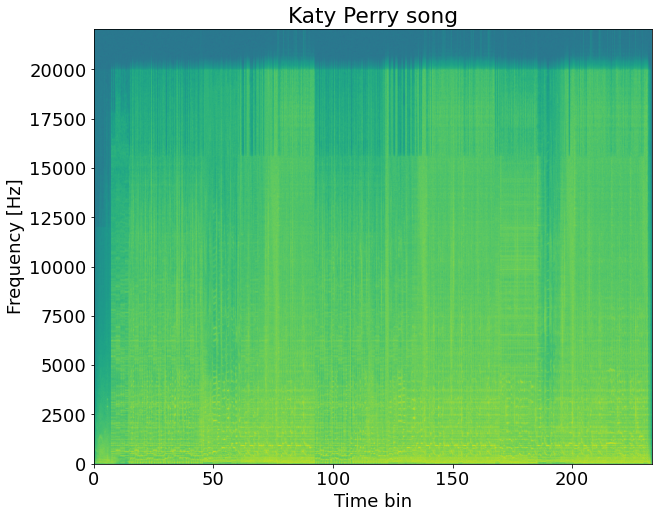

In [15]:
fig1 = plt.figure(figsize=(10, 8), facecolor='white')
extent = 0, np.amax(t1), freqs1[0], freqs1[-1]
Z = 10.0 * np.log10(spec1)
Z = np.flipud(Z)
plt.imshow(Z, cmap='viridis', extent=extent)
plt.xlabel('Time bin')
plt.ylabel('Frequency [Hz]')
plt.title('Katy Perry song')
plt.axis('auto')
ax = plt.gca()
ax.set_xlim([0, extent[1]])
ax.set_ylim([freqs1[0], freqs1[-1]])
plt.show()

In [16]:
def identify_peaks(im, *args, **kwargs):
    # Encapsulate this fulctionality for possible replacements of the function that generates `coordinates`.
    coordinates = peak_local_max(im, *args, **kwargs)
    
    time_coordinates = coordinates[:, 1]
    freq_coordinates = coordinates[:, 0]
    
    time_sort_ind = np.argsort(time_coordinates)
    
    return (freq_coordinates[time_sort_ind],
            time_coordinates[time_sort_ind])

In [17]:
# This function returns a booleans mask, which defines the target zone.
def define_target_zone(dt):
    tz_start = 0
    
    tz_end_type = 'count'
    tz_end = 300
    
    tz_upper = np.inf
    tz_lower = -np.inf
    
    max_tz_length = 10
    
    # 1. Define the starting point of the target zone (and also include all consecutive points).
    target_zone = (dt > tz_start)
    
    # 2. Define the ending point of the target zone.
    # If `tz_end_type` equals 'count', the number of points in the zone is considered rather than the time.
    if tz_end_type == 'count':
        # Sum per column and take only those points where the sum is within the limit of `tz_end`.
        target_zone = target_zone & (np.cumsum(target_zone, axis = 0) <= tz_end)
        
        # Nonetheless apply a upper contraint for the time to keep the target zone resonably sized.
        target_zone = target_zone & (dt <= tz_start + max_tz_length)
    else:
        target_zone = target_zone & (dt <= tz_end)
        
    # 3. Apply lower and upper bounds for the frequency range of the target zone.
    #TODO:
    
    return target_zone

In [18]:
def extract_pairs(im, freqs, t, *args, **kwargs):
    freq_coords, time_coords = identify_peaks(im, *args, **kwargs)
    
    # Explicitly reshape `freqs` and `t` to make them column vectors.
    freqs = np.reshape(freqs[freq_coords], (-1, 1))
    t = np.reshape(t[time_coords], (-1, 1))
    
    # Calculate `dt` 
    # The first row of `dt` has elements t[0] - t[0], t[0] - t[1], t[0] - t[2], ...
    # The first column of `dt` stores all (positve, i.e. forward looking) Δt with reference to t[0].
    dt = t - t.T
    
    target_zone = define_target_zone(dt)

    # Convert `target_zone` to int to be able to use NaNs.
    target_zone = target_zone.astype(float)
    # Set all values in the target zone mask to NaN that are not within the respective target zone.
    target_zone[target_zone == 0] = np.nan
    
    # Transpose `freqs` and `t` such that they become row vectors and each column (which only has one element) is related to the columns of `dt`.
    f_anchor = freqs.T * target_zone
    t_anchor = t.T * target_zone
    f_2 = freqs * target_zone
    dt = dt * target_zone
    
    return np.stack((f_anchor, f_2, dt, t_anchor), axis=2)

In [21]:
def extract_coord_pairs(im, freqs, t, *args, **kwargs):
    freq_coords, time_coords = identify_peaks(im, *args, **kwargs)
    
    # Explicitly reshape `freqs` and `t` to make them column vectors.
    freqs = np.reshape(freq_coords, (-1, 1))
    t = np.reshape(time_coords, (-1, 1))
    
    # Calculate `dt` 
    # The first row of `dt` has elements t[0] - t[0], t[0] - t[1], t[0] - t[2], ...
    # The first column of `dt` stores all (positve, i.e. forward looking) Δt with reference to t[0].
    dt = t - t.T
    
    target_zone = define_target_zone(dt)

    # Convert `target_zone` to int to be able to use NaNs.
    target_zone = target_zone.astype(float)
    # Set all values in the target zone mask to NaN that are not within the respective target zone.
    target_zone[target_zone == 0] = np.nan
    
    # Transpose `freqs` and `t` such that they become row vectors and each column (which only has one element) is related to the columns of `dt`.
    f_anchor = freqs.T * target_zone
    t_anchor = t.T * target_zone
    f_2 = freqs * target_zone
    dt = dt * target_zone
    
    return np.stack((f_anchor, f_2, dt, t_anchor), axis=2)

In [22]:
value_pairs = extract_pairs(spec1, freqs1, t1, min_distance=20, threshold_abs=20)
coord_pairs = extract_coord_pairs(spec1, freqs1, t1, min_distance=20, threshold_abs=20)

In [23]:
# This function only works with scalar values.
# TODO: Change this!!
def hash_by_sobot(freq_1, freq_2, dt):
    try:
        freq_1 = int(freq_1)
        freq_2 = int(freq_2)
        dt = int(dt)
    except ValueError:
        return np.nan
    
    return (dt & 0x0000FFFF) | ((freq_2 & 0xFF) << 16) | ((freq_1 & 0xFF) << 24)

In [24]:
# Create a function that also accepts np.arrays.
hashing = np.vectorize(hash_by_sobot)

In [27]:
# Create a one-dimensionsal column vector
coord_pairs_rs = np.reshape(coord_pairs, (-1, 4), order='F')

nans_per_row = np.isnan(coord_pairs_rs).sum(axis=1)
# Remove all row that contain at least one NaN (i.e. only keep those where `nans_per row` equals 0)
coord_pairs_rs = coord_pairs_rs[nans_per_row == 0, :]

In [30]:
coord_pairs_rs.shape

(41176, 4)

In [29]:
import time

for i in range(5):
    start = time.time()
    hash_vals = hashing(coord_pairs[:,:,0], coord_pairs[:,:,1], coord_pairs[:,:,2])
    print(time.time() - start)
    
    start = time.time()
    hash_vals_rs = hashing(coord_pairs_rs[:,0], coord_pairs_rs[:,1], coord_pairs_rs[:,2])
    print(time.time() - start)
    
    print("--")

C:\Users\pizza\miniconda3\envs\Application_Project\lib\site-packages\numpy\lib\function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


9.897740364074707
0.027924537658691406
--
9.833731412887573
0.025898456573486328
--
9.866610527038574
0.024965524673461914
--
9.932404279708862
0.02692699432373047
--
9.918504476547241
0.025899648666381836
--


# Dateabase requirements

Information needed to store:

**Table `advertiser`**
* <u>Advertiser ID</u>
* Advertiser
* Advertisement No
* Advertisement ID

**Table `advertisement`**
* <u>Advertisement ID</u>
* Advertisement description

**Table `fingerprint`**
* <u>Hash value</u>
* <u>Hash position</u> (<font color="red"> Does it need to be part of the key?</font>)
* Advertisement ID

Relations:

**`advertiser`** : **`advertisement`**: **1:N**</br>
**`advertisement`** : **`fingerprint`**: **1:N** (desired); **M:N** (in the case of hash collisions)

# Remarks

## 1NF: Values need to be atomic
## 2NF: No non-key value is allowed to depend only on a part of the primary key attributes
## 3NF: No non-key value is allowed to depend on a key in a transitive manner.